In [89]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets,transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torchsummary import summary

from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, f1_score, classification_report

In [2]:
%matplotlib inline
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

In [4]:
train_data = datasets.CIFAR10(train = True,transform = transform, root= "C:\\Users\\supro\\ML-DL", download = True)

In [5]:
test_data = datasets.CIFAR10(train = False,transform = transform, root= "C:\\Users\\supro\\ML-DL", download = True)

In [6]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: C:\Users\supro\ML-DL
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261))
           )

In [7]:
test_data

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: C:\Users\supro\ML-DL
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261))
           )

In [8]:
train_loader = DataLoader(train_data, batch_size=64, shuffle= True)
test_loader = DataLoader(test_data, batch_size=64, shuffle= True)

In [9]:
image, label = train_data[0]

In [10]:
image.size()

torch.Size([3, 32, 32])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


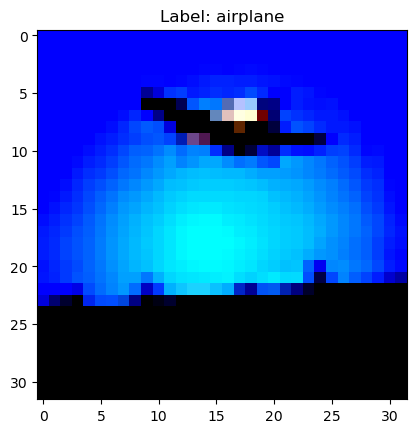

In [18]:
image, label = train_data[np.random.randint(50000)]

# PyTorch tensors are (C, H, W), but Matplotlib needs (H, W, C)
# We use .permute(1, 2, 0) to swap the dimensions
plt.imshow(image.permute(1, 2, 0))
plt.title(f"Label: {train_data.classes[label]}")
plt.show()

#### CNN Layer set up

In [59]:
(32-3+2)+1

32

In [60]:
(16-3+2)+1

16

In [21]:
3*3*12

108

In [67]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 16, 3, 1, padding=1) #output 32x32x16
        self.conv2 = nn.Conv2d(16, 32, 3, 1, padding=1) #output: 16x16x32
        self.conv3 = nn.Conv2d(32, 64, 3, 1, padding=1) #output: 8x8x64
        self.pool = nn.MaxPool2d(2,2)
        
    def forward(self,x):

        x= self.pool(F.relu(self.conv1(x))) #output: 16x16x16
        x= self.pool(F.relu(self.conv2(x))) #output: 8x8x32
        x= self.pool(F.relu(self.conv3(x))) #output: 4x4x64

        x = x.reshape(-1,1024)

        return x

In [68]:
class_names = train_data.classes
print(f"Class names: {class_names}")

len(class_names)

Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


10

In [69]:
class DeepNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1 = nn.Linear(1024,512,bias = True)
        self.fc2 = nn.Linear(512,128)
        self.out = nn.Linear(128,10)

    def forward(self,x):

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)

        return x

In [70]:
class FullModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = CNN()
        self.dnn = DeepNN()

    def forward(self,x):
        x = self.cnn(x) 
        pred = self.dnn(x)

        return pred

In [100]:
cnn_model = CNN()
model = FullModel()

In [101]:
cnn_model.forward(image).shape

torch.Size([64, 1024])

In [102]:
model.parameters

<bound method Module.parameters of FullModel(
  (cnn): CNN(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dnn): DeepNN(
    (fc1): Linear(in_features=1024, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=128, bias=True)
    (out): Linear(in_features=128, out_features=10, bias=True)
  )
)>

In [103]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr =0.0005)

In [104]:
total_loss = 0
for image, label in train_loader:

    optimizer.zero_grad()
    pred = model(image)
    loss = criterion(pred, label)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

total_loss/len(train_loader)

1.5688767853905172

In [105]:
losses = []

for i in range(15):
    batch_loss = 0
    for image, label in train_loader:

        optimizer.zero_grad()
        pred = model(image)
        loss = criterion(pred, label)
        loss.backward()
        optimizer.step()

        batch_loss += loss.item()
    epoch_loss = batch_loss/len(train_loader)
    losses.append(epoch_loss)
    

In [106]:
torch.save(model.state_dict(), 'cifar10_model.pth')

Text(0, 0.5, 'error')

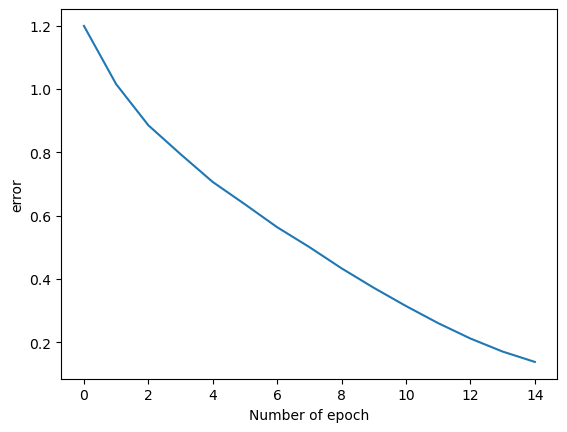

In [108]:
plt.plot(np.arange(15),losses)
plt.xlabel('Number of epoch')
plt.ylabel('error')

In [109]:
summary(model, (3,32,32), device = "cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
         MaxPool2d-2           [-1, 16, 16, 16]               0
            Conv2d-3           [-1, 32, 16, 16]           4,640
         MaxPool2d-4             [-1, 32, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          18,496
         MaxPool2d-6             [-1, 64, 4, 4]               0
               CNN-7                 [-1, 1024]               0
            Linear-8                  [-1, 512]         524,800
            Linear-9                  [-1, 128]          65,664
           Linear-10                   [-1, 10]           1,290
           DeepNN-11                   [-1, 10]               0
Total params: 615,338
Trainable params: 615,338
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/

In [110]:
all_labels = []
all_preds = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        
        # Get the predicted class (the index of the max score)
        _, predicted = torch.max(outputs, 1)
        
        all_labels.extend(labels.numpy())
        all_preds.extend(predicted.numpy())

In [111]:
print("--- Detailed Report per Digit ---")

report = classification_report(all_labels, all_preds,target_names = train_data.classes)

print(report)

--- Detailed Report per Digit ---
              precision    recall  f1-score   support

    airplane       0.73      0.81      0.76      1000
  automobile       0.85      0.84      0.85      1000
        bird       0.61      0.67      0.64      1000
         cat       0.61      0.45      0.52      1000
        deer       0.67      0.70      0.69      1000
         dog       0.62      0.67      0.64      1000
        frog       0.79      0.80      0.80      1000
       horse       0.80      0.75      0.78      1000
        ship       0.85      0.80      0.83      1000
       truck       0.77      0.80      0.78      1000

    accuracy                           0.73     10000
   macro avg       0.73      0.73      0.73     10000
weighted avg       0.73      0.73      0.73     10000



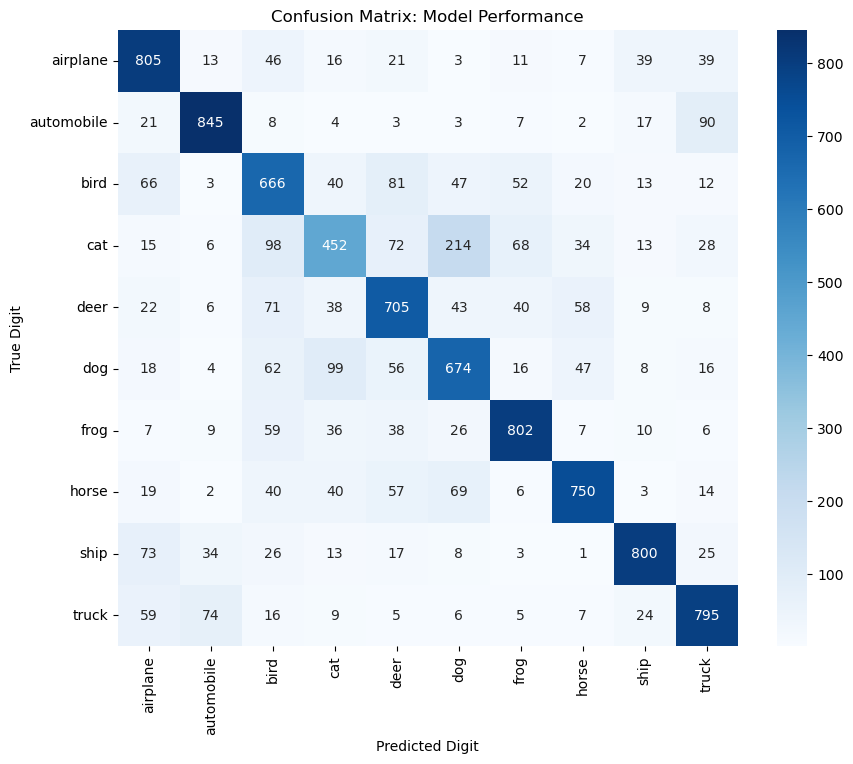

In [112]:
cm = confusion_matrix(all_labels, all_preds)

# 3. Plot using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=train_data.classes, yticklabels=train_data.classes)

plt.xlabel('Predicted Digit')
plt.ylabel('True Digit')
plt.title('Confusion Matrix: Model Performance')
plt.show()

In [113]:
def predict_and_show(i):
    image, label = train_data[i]
    model.eval()

    with torch.no_grad():
        output = model(image.unsqueeze(0))
        probabilities = torch.nn.functional.softmax(output, dim=1)[0]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    img_display = image.permute(1, 2, 0).cpu().numpy()
    
    # If you used Normalize, the image might look weird. 
    # Optional: Un-normalize here if you want it to look "natural" again.
    ax1.imshow(img_display)
    ax1.set_title(f"Actual: {train_data.classes[label]}") # FIX 2: Label Name
    ax1.axis('off')

    # Right: The Model's Confidence
    x_pos = np.arange(10)
    # FIX 3: Ensure CPU for numpy conversion
    probs_np = probabilities.cpu().numpy() 
    
    ax2.bar(x_pos, probs_np, align='center', color='skyblue')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(train_data.classes, rotation=45) # Use names for x-axis too!
    ax2.set_ylabel('Probability')
    ax2.set_title('Model Prediction Confidence')
    ax2.set_ylim(0, 1.1)

    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


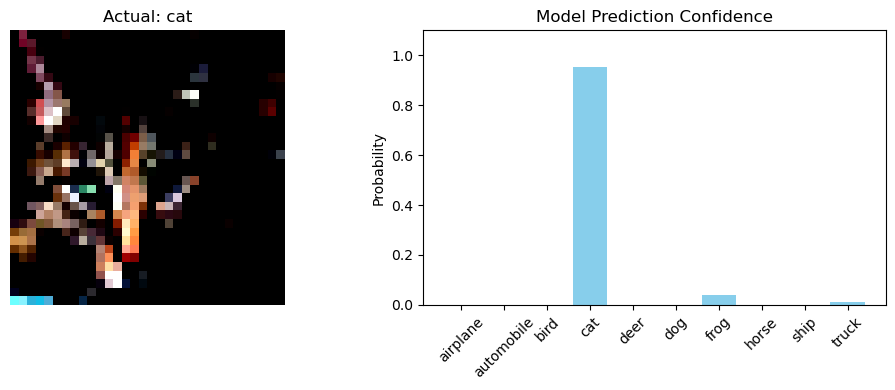

In [123]:
predict_and_show(np.random.randint(10000))